In [1]:
import warnings
import os
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, reading CSV file
import seaborn as sns # statistical data visualization
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt # data visualization
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
from IPython.display import Audio, display
import librosa # audio analysis library for sound signal processing.
import librosa.display # visualization functions for sound signal.
import soundfile as sf
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, SimpleRNN, TimeDistributed, Embedding
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, accuracy_score, precision_score, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC

Load Files from Directory

In [2]:
# Set the path to the RAVDESS dataset directory
working_directory = os.getcwd()
dataset_path = working_directory + '/ASVP-ESD/Audio'
# dataset_path = working_directory + '/ravdess/audio_speech_actors_01-24'
print(dataset_path)

/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANALYTICS/Projects/Assignment/Dissertation/ASVP-ESD/Audio


Feature Extraction

In [3]:
# Define the list of emotions
# emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
emotions = ["boredom", "neutral", "happiness", "sadness", "anger", "fear", "disgust", "surprise", "excitement", "pleasure", "pain", "disappointment", "breath"]

# Initialize empty lists to store features and labels
features = []
labels = []
path = []

# Iterate through the dataset directory
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        # Extract the emotion label from the filename
        try:
            emotion = emotions[int(file[7:8]) - 1]
        except (ValueError, IndexError):
            print(f"Invalid file name format: {file}")
            continue
        
        # Load the audio file using Librosa
        file_path = os.path.join(root, file)
        audio, sr = librosa.load(file_path, sr=None)
        
        # Extract features (e.g., MFCCs) from the audio
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        
        # Append the features and label to the respective lists
        features.append(mfcc.T) # Transpose the mfcc array
        labels.append(emotion)
        path.append(file_path)

# Convert the lists to NumPy arrays
features = np.array(features, dtype=object)
labels = np.array(labels)
path = np.array(path, dtype=object)

# Print the shape of the features and labels arrays
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Invalid file name format: .DS_Store
Features shape: (12081,)
Labels shape: (12081,)


In [4]:
print(labels)

['neutral' 'surprise' 'anger' ... 'surprise' 'surprise' 'happiness']


In [5]:
# Create a DataFrame with emotion labels and features
df_emotions = pd.DataFrame({'Emotions': labels, 'Features': features, 'Files': path})
df_emotions

,Emotions,Features,Files
0,neutral,"[[-238.38966, 115.25047, 1.45046, 26.364645, 1...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1,surprise,"[[-625.8668, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
2,anger,"[[-545.64166, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
3,neutral,"[[-540.7256, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
4,neutral,"[[-540.0327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
...,...,...,...
12076,neutral,"[[-375.03525, 115.85985, 25.505497, 46.249214,...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
12077,neutral,"[[-713.8606, 5.8378654, 5.814377, 5.775393, 5....",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
12078,surprise,"[[-449.00485, 75.11812, 4.537654, 19.372986, 3...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
12079,surprise,"[[-480.70398, 85.943665, -21.062347, -16.14809...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...


In [6]:
df_emotions.head()

,Emotions,Features,Files
0,neutral,"[[-238.38966, 115.25047, 1.45046, 26.364645, 1...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1,surprise,"[[-625.8668, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
2,anger,"[[-545.64166, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
3,neutral,"[[-540.7256, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
4,neutral,"[[-540.0327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...


In [7]:
df_emotions.tail()

,Emotions,Features,Files
12076,neutral,"[[-375.03525, 115.85985, 25.505497, 46.249214,...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
12077,neutral,"[[-713.8606, 5.8378654, 5.814377, 5.775393, 5....",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
12078,surprise,"[[-449.00485, 75.11812, 4.537654, 19.372986, 3...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
12079,surprise,"[[-480.70398, 85.943665, -21.062347, -16.14809...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
12080,happiness,"[[-529.57214, 53.729134, -28.523502, 4.3060484...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...


In [8]:
df_emotions.dtypes

Emotions    object
Features    object
Files       object
dtype: object

In [9]:
# Checking for missing data using the cleaning tehniques
emotions_null = df_emotions.isnull()
#adverts_null = df_adverts.isnull().any()
emotions_null.sum()

Emotions    0
Features    0
Files       0
dtype: int64

In [10]:
df_emotions['Emotions'].value_counts()

Emotions
happiness     1853
neutral       1799
surprise      1507
sadness       1487
anger         1442
boredom       1237
fear          1141
disgust        886
excitement     370
breath         359
Name: count, dtype: int64

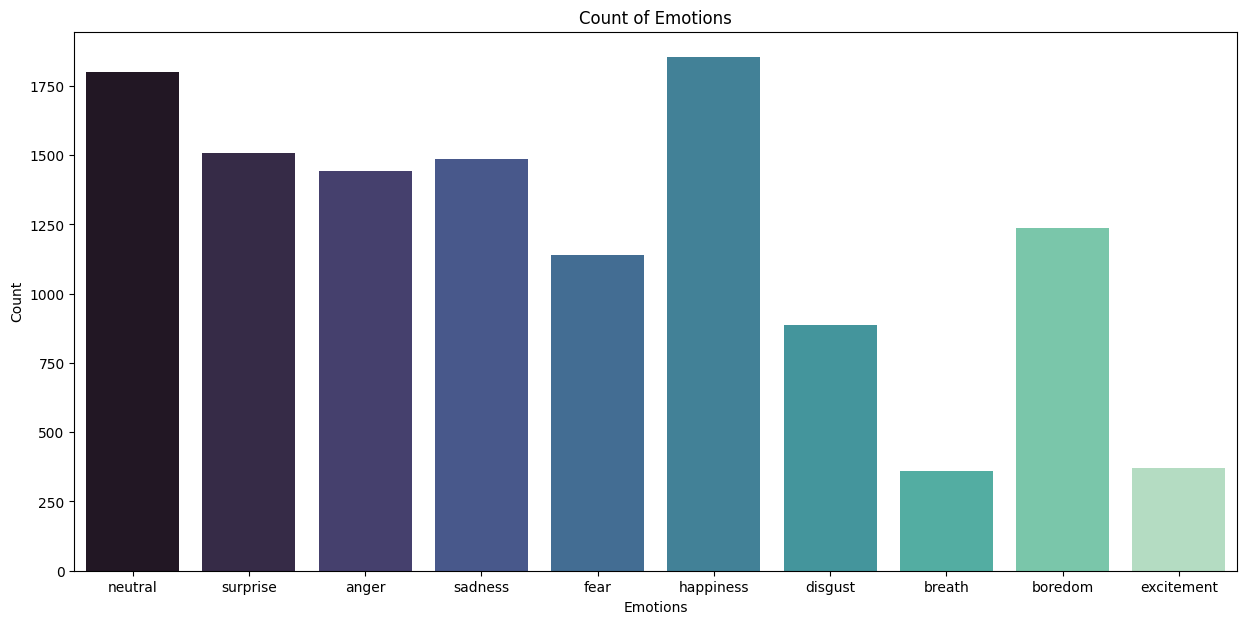

In [11]:
# Suppress FutureWarning about is_categorical_dtype
warnings.filterwarnings("ignore", category=FutureWarning)

# Set the figures of the plot
fig, ax = plt.subplots(figsize=(15, 7))

# Create a bar plot using Seaborn
sns.countplot(data=df_emotions, x='Emotions', palette='mako', ax=ax)

# Set the plot title and axis labels
plt.title('Count of Emotions')
plt.ylabel('Count')
plt.xlabel('Emotions')

# Show the plot
plt.show()

# Reset warnings filter
warnings.filterwarnings("default", category=FutureWarning)

In [12]:
# Your create_wave_spect function, modified to return plots
def create_wave_spect(emotion, cmap='magma'):
    path = np.array(df_emotions['Files'][df_emotions['Emotions'] == emotion])[0]
    data, sampling_rate = librosa.load(path)
    
    plt.figure(figsize=(15, 4))
    plt.title('Waveplot for {} emotion'.format(emotion.capitalize()), size=15)
    # librosa.display.waveshow(data, sr=sampling_rate)
    plt.plot(data, color='b')  # Plot the waveform
    plt.show()
    
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    plt.figure(figsize=(15, 4))
    plt.title('Spectrogram for {} emotion'.format(emotion.capitalize()), size=15)
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz', cmap=cmap)
    plt.colorbar()
    plt.show()
    
    display(Audio(path))

Plots of Boredom


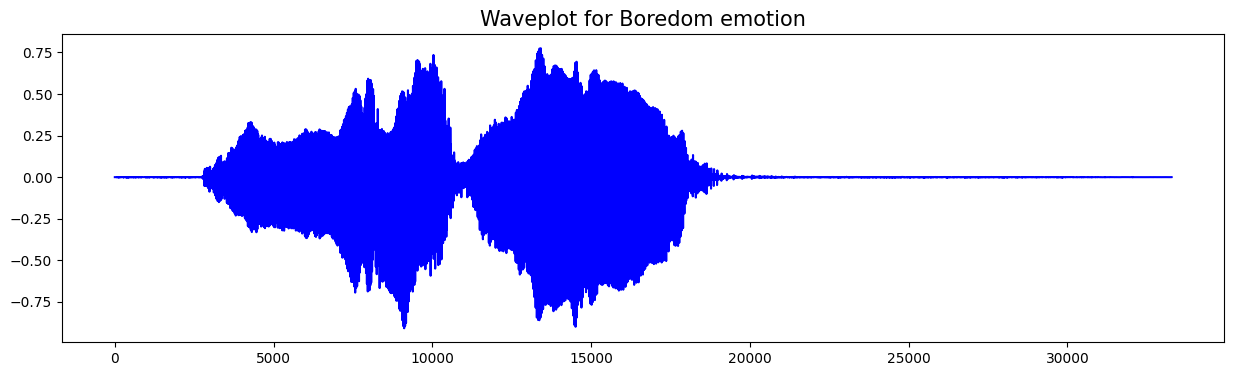

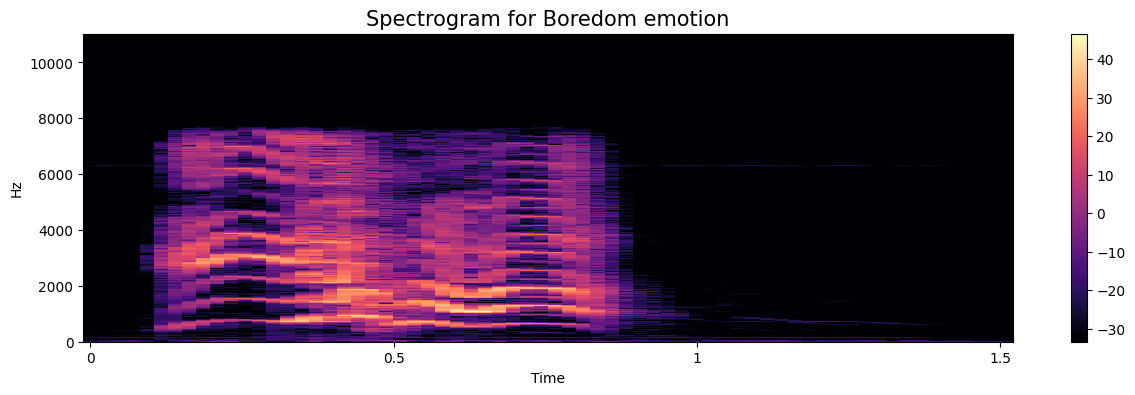

Plots of Neutral


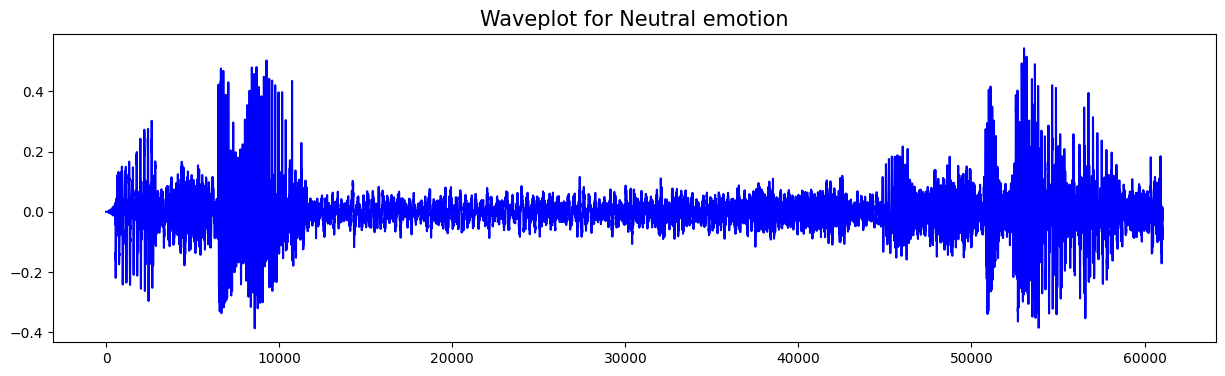

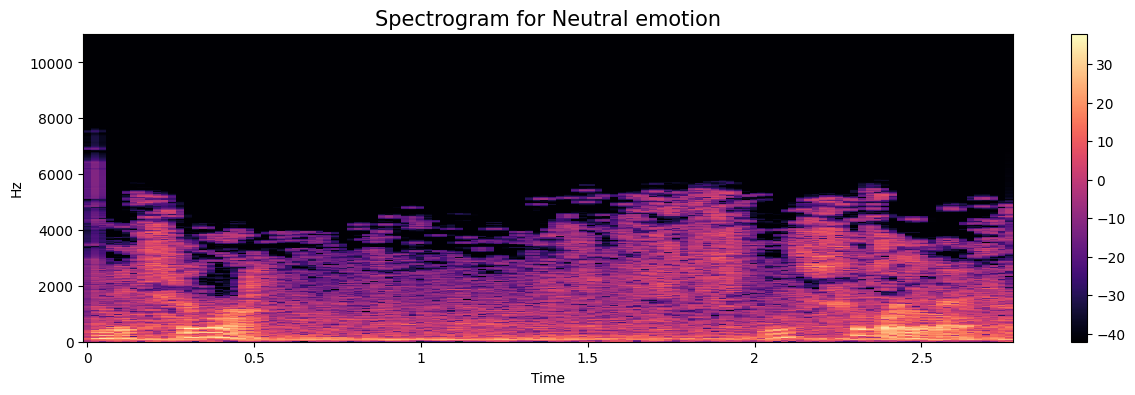

Plots of Happiness


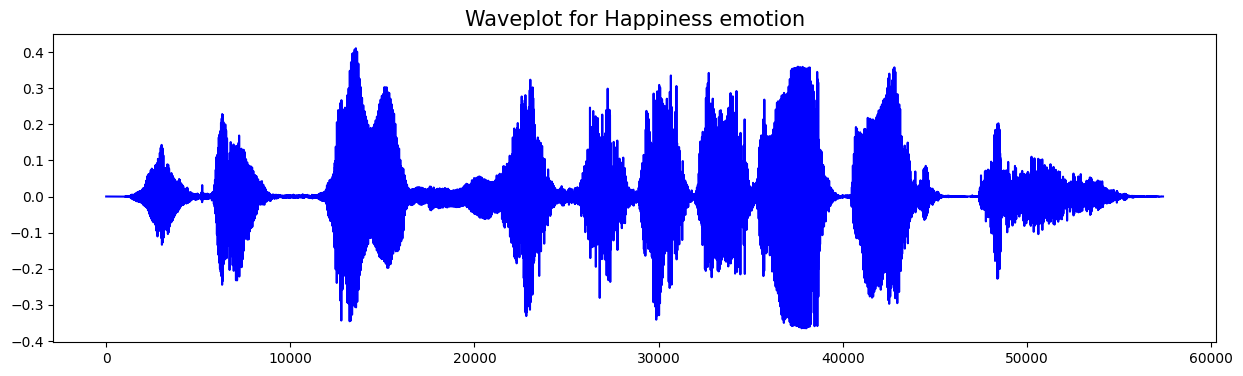

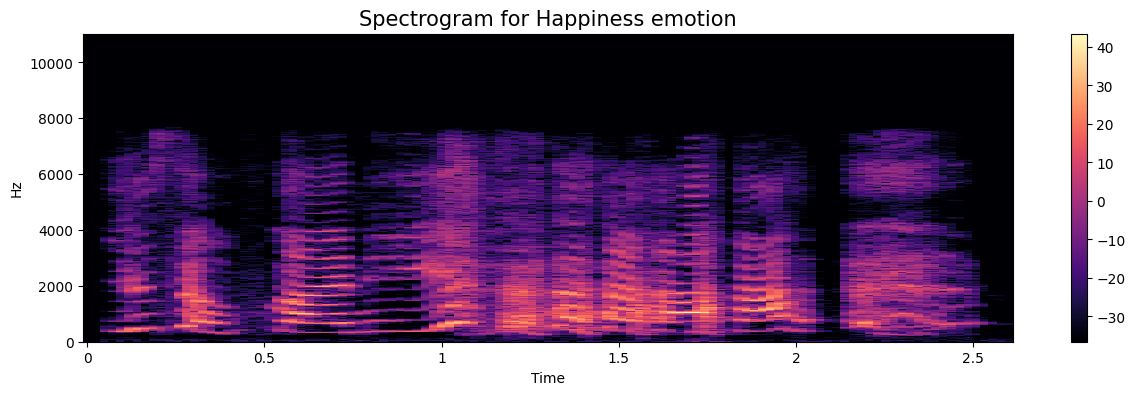

Plots of Sadness


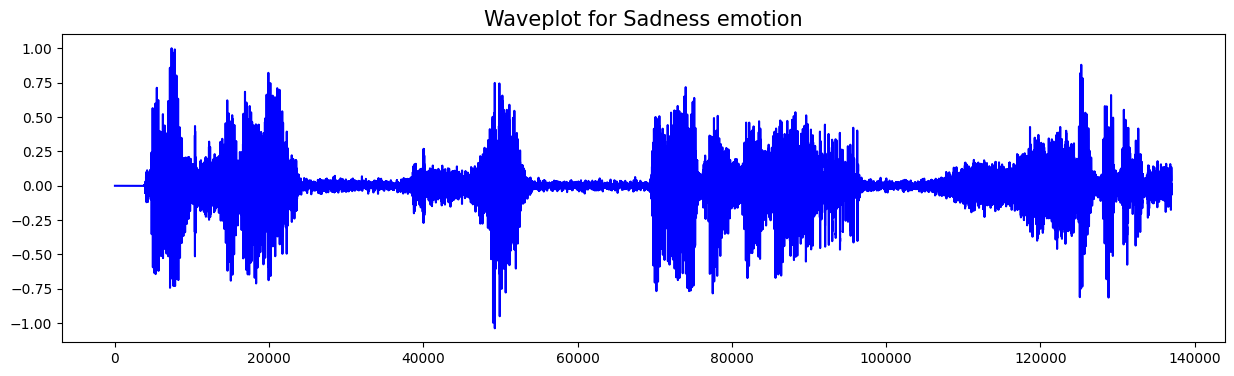

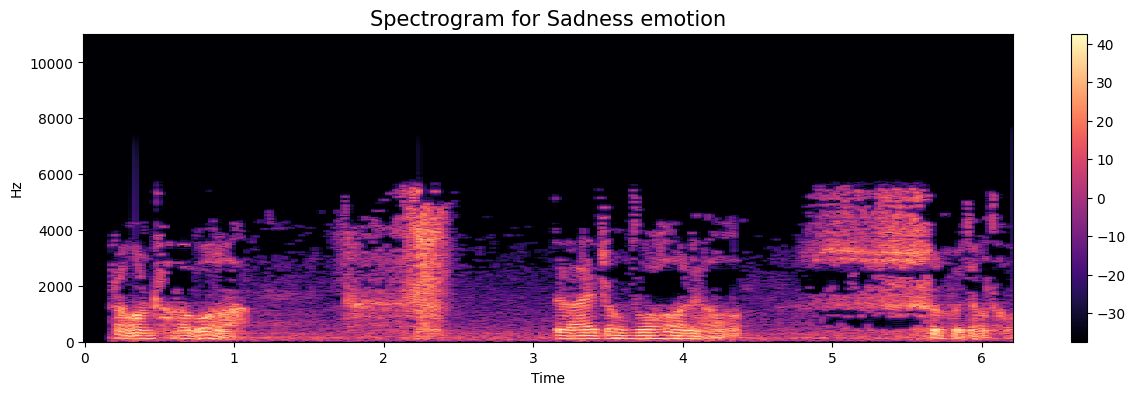

Plots of Anger


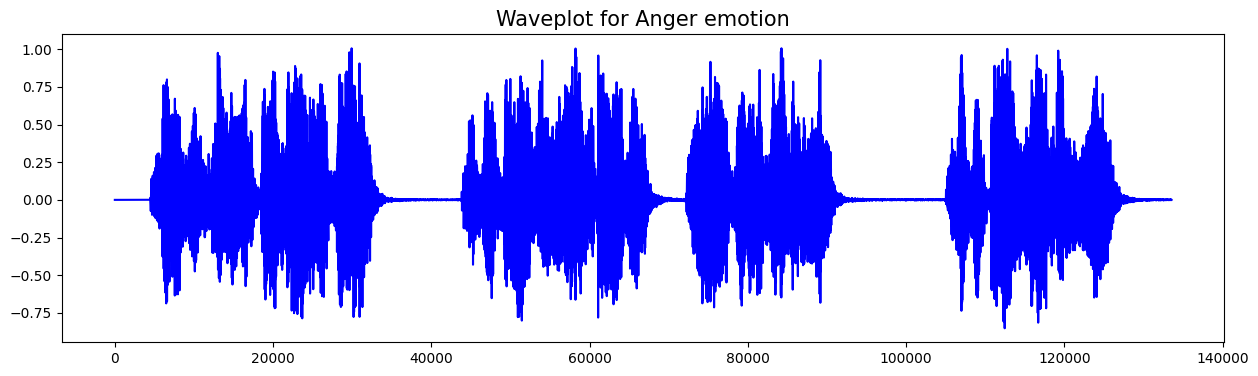

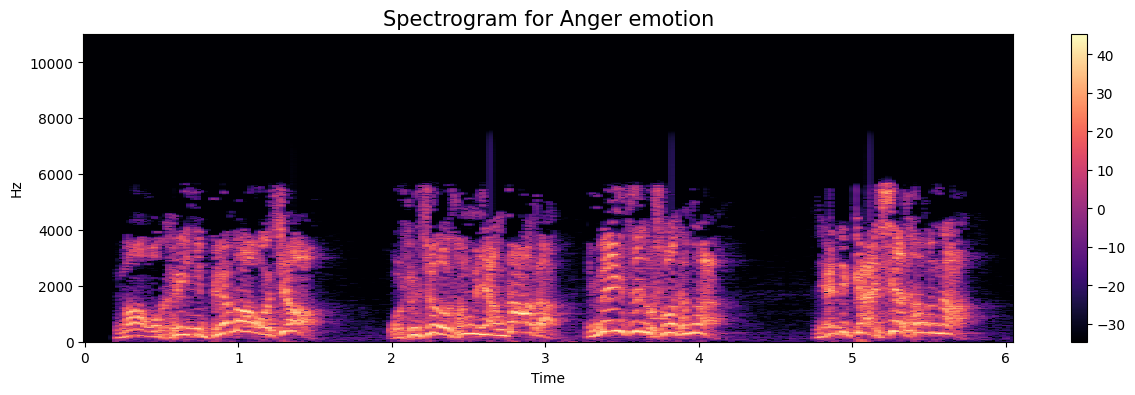

Plots of Fear


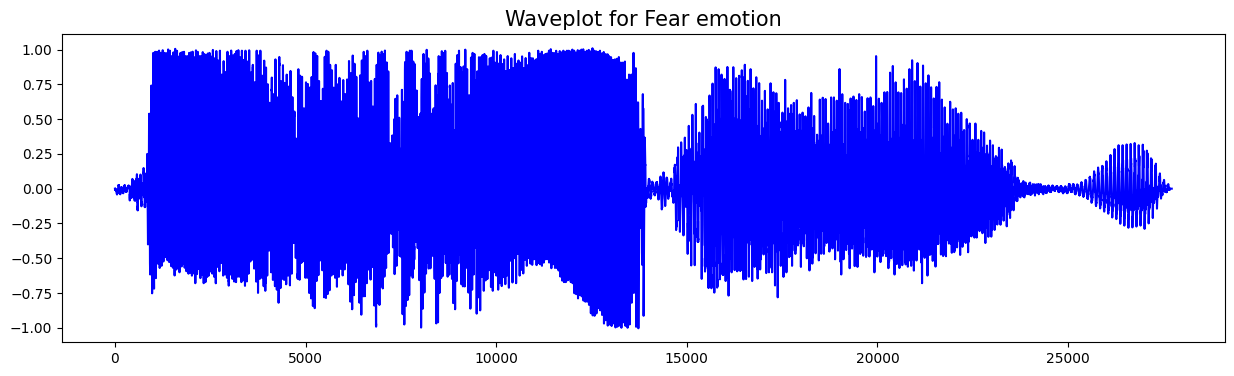

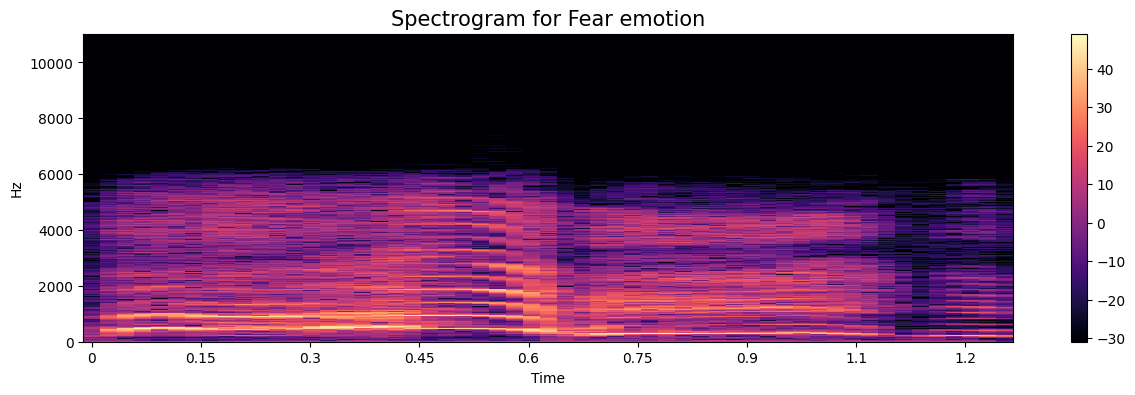

Plots of Disgust


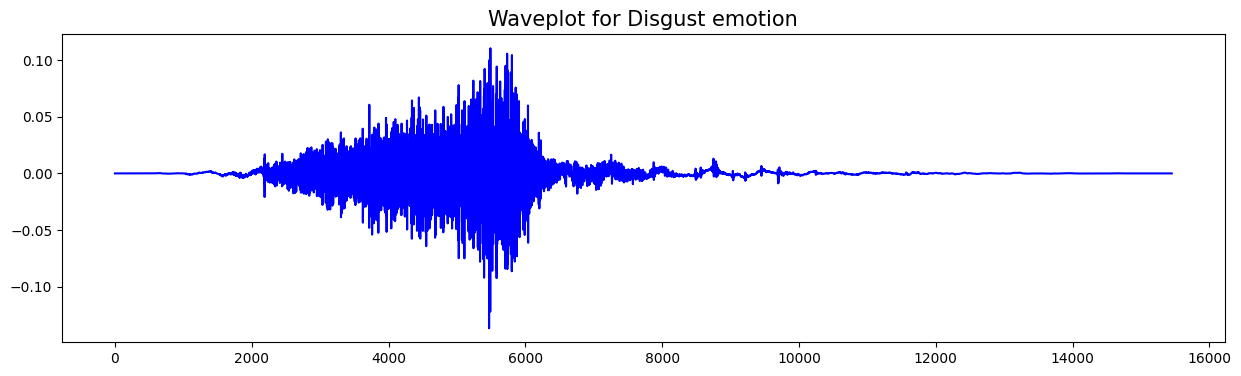

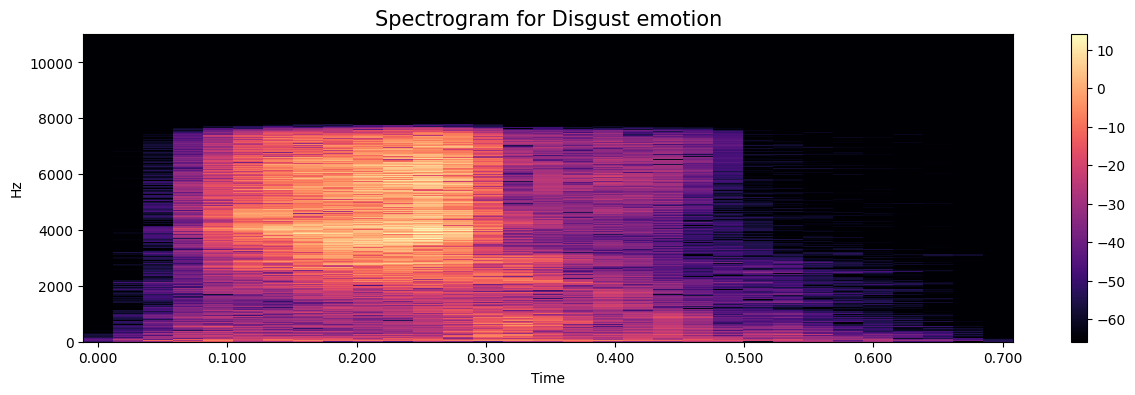

Plots of Surprise


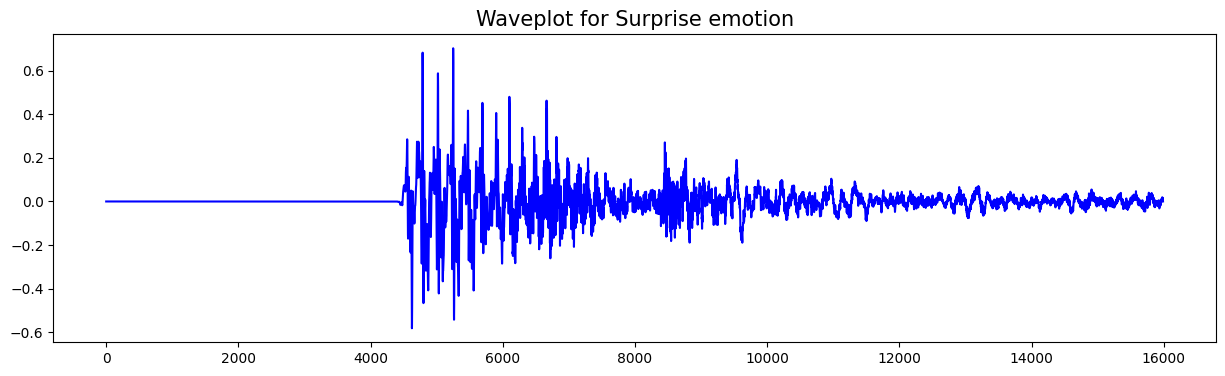

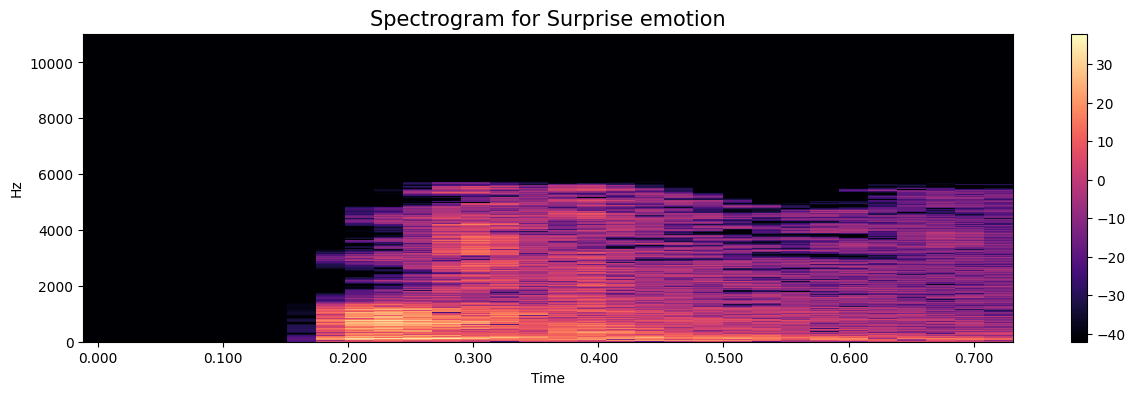

Plots of Excitement


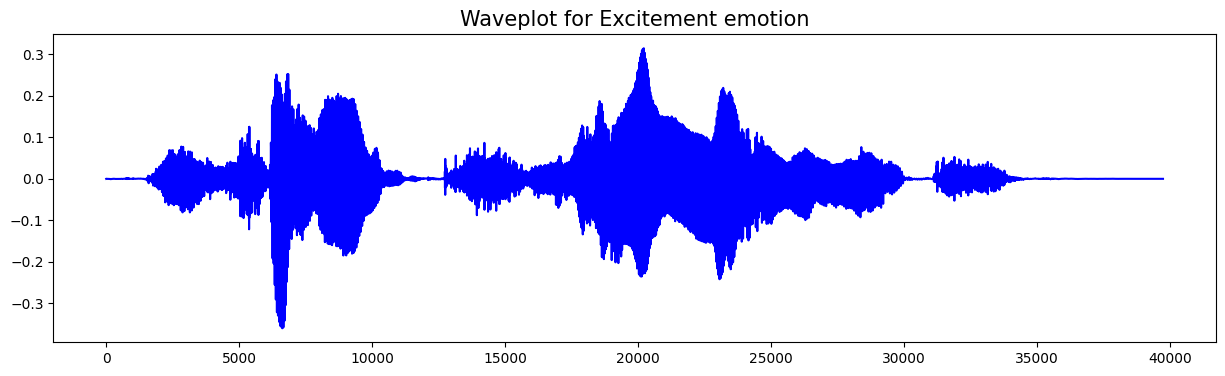

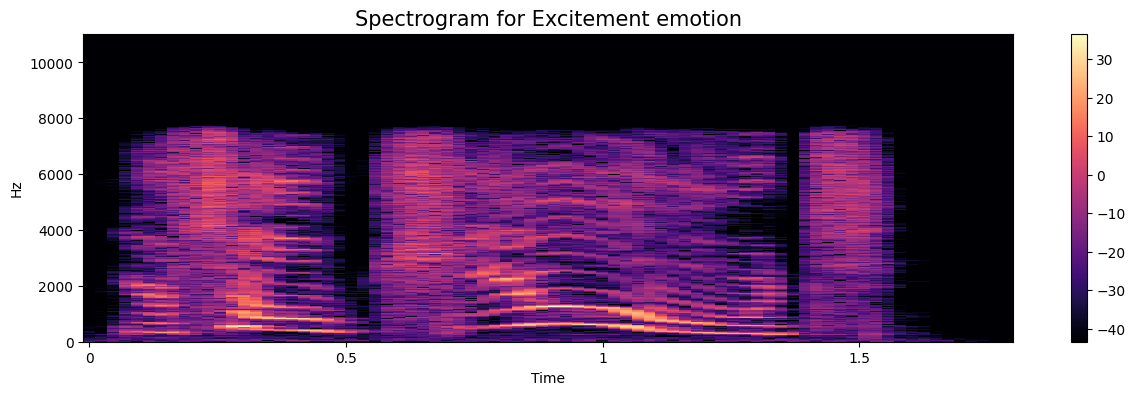

Plots of Breath


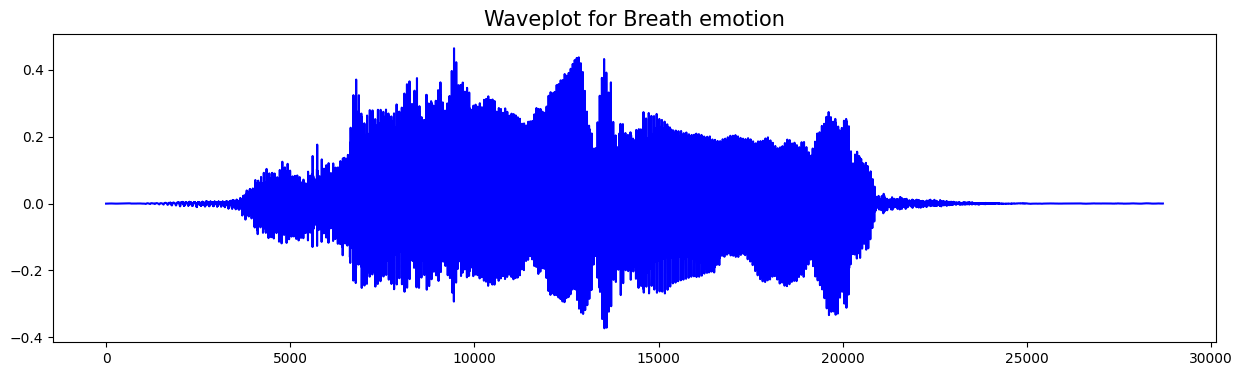

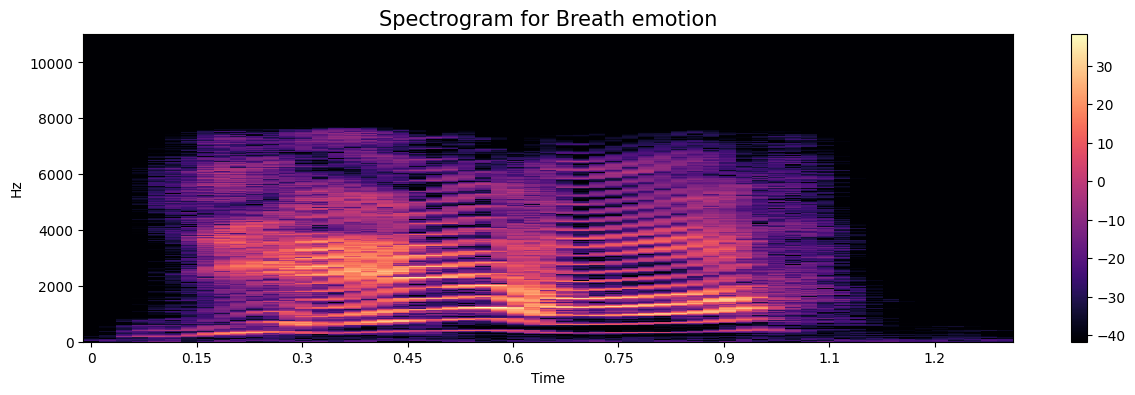

In [13]:
# List of emotions
# emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
# emotions = ["sadness", "happiness", "fear", "neutral", "boredom", "disgust"]
emotions = ["boredom", "neutral", "happiness", "sadness", "anger", "fear", "disgust", "surprise", "excitement", "breath"]

# Loop through emotions and create/display plots
for emotion in emotions:
    print('Plots of', emotion.capitalize())
    create_wave_spect(emotion, cmap='magma')

Data Augmentation

In [14]:
# Define the augment_audio function
def augment_audio(audio, sr):
    # Time stretching (stretch the audio in time)
    time_stretch = librosa.effects.time_stretch(audio, rate=1.2)  # Adjust the rate
    
    # Pitch shifting (change the pitch of the audio)
    pitch_shift = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)  # Provide sr here and adjust n_steps
    
    # Adding random noise
    noise = np.random.normal(0, 0.02, len(audio))  # Adjust the noise level
    
    # Combine the augmented versions
    augmented_audio = audio[:min(len(audio), len(time_stretch), len(pitch_shift))] + \
                     time_stretch[:min(len(audio), len(time_stretch), len(pitch_shift))] + \
                     pitch_shift[:min(len(audio), len(time_stretch), len(pitch_shift))] + \
                     noise[:min(len(audio), len(time_stretch), len(pitch_shift))]
    
    return augmented_audio

In [15]:
# Define the output directory for augmented audio files
output_directory = working_directory + '/Augmented_audio'

# Loop through your dataset and apply augmentation to each audio file
# for root, dirs, files in os.walk(dataset_path):
#     for file in files:
#         audio_path = os.path.join(root, file)
#         if not audio_path.endswith(".wav"):
#             print(f"Skipping non-wav file: {audio_path}")
#             continue
#         try:
#             audio, sr = librosa.load(audio_path, sr=None)
            
#             # Augment the audio
#             augmented_audio = augment_audio(audio, sr)
            
#             # Define a new filename for the augmented audio in the output directory
#             output_filename = os.path.join(output_directory, file.replace('.wav', '_augmented.wav'))
            
#             # Save the augmented audio to the output directory
#             sf.write(output_filename, augmented_audio, sr)
#             # print(f"Augmented and saved to: {output_filename}")
#         except Exception as e:
#             print(f"Error augmenting {audio_path}: {str(e)}")

Feature Engineering

In [16]:
# Load and preprocess your dataset from df_emotions (replace with your data loading code)
def load_and_preprocess_data():
    # Assuming df_emotions has columns 'Files' for file paths, 'Emotions' for emotion labels, and 'Features' for MFCCs
    mfcc_features = df_emotions['Features'].tolist()
    emotions = df_emotions['Emotions'].tolist()

    return mfcc_features, emotions

Support Vector Machine (SVM)

In [17]:
# Load and preprocess the dataset
X_mfcc_features, y = load_and_preprocess_data()

# Check the shapes of MFCC features
mfcc_shapes = [mfcc.shape for mfcc in X_mfcc_features]

# Verify if all MFCC feature shapes are the same
if all(shape == mfcc_shapes[0] for shape in mfcc_shapes):
    print("MFCC shapes are consistent:", mfcc_shapes[0])
else:
    print("MFCC shapes are not consistent:", mfcc_shapes)

# Pad MFCC sequences to have the same length (use the maximum sequence length)
max_length = max([len(mfcc) for mfcc in X_mfcc_features])
X_mfcc_features_padded = pad_sequences(X_mfcc_features, maxlen=max_length, padding='post', dtype='float32')

# Reshape the features to 2D (number of samples, number of features)
features_reshaped = X_mfcc_features_padded.reshape(X_mfcc_features_padded.shape[0], -1)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_reshaped, y, test_size=0.2, random_state=42
)

MFCC shapes are not consistent: [(87, 13), (23, 13), (190, 13), (115, 13), (27, 13), (98, 13), (195, 13), (119, 13), (72, 13), (342, 13), (343, 13), (42, 13), (30, 13), (357, 13), (164, 13), (342, 13), (190, 13), (123, 13), (72, 13), (41, 13), (342, 13), (40, 13), (83, 13), (31, 13), (82, 13), (26, 13), (22, 13), (60, 13), (35, 13), (23, 13), (342, 13), (329, 13), (342, 13), (69, 13), (24, 13), (85, 13), (23, 13), (127, 13), (47, 13), (72, 13), (70, 13), (45, 13), (64, 13), (69, 13), (119, 13), (47, 13), (46, 13), (31, 13), (36, 13), (36, 13), (169, 13), (41, 13), (55, 13), (328, 13), (113, 13), (409, 13), (62, 13), (65, 13), (69, 13), (18, 13), (96, 13), (42, 13), (148, 13), (61, 13), (48, 13), (342, 13), (102, 13), (85, 13), (185, 13), (342, 13), (32, 13), (145, 13), (37, 13), (45, 13), (87, 13), (32, 13), (125, 13), (75, 13), (154, 13), (271, 13), (123, 13), (133, 13), (23, 13), (37, 13), (19, 13), (46, 13), (342, 13), (107, 13), (57, 13), (91, 13), (93, 13), (49, 13), (342, 13), (3

In [18]:
# Create a machine learning pipeline with feature scaling and an SVM classifier
model_svm = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features to have mean=0 and variance=1
    ('pca', PCA(n_components=50)),  # Principal Component Analysis (PCA) for dimensionality reduction
    ('svm', SVC(kernel='linear', C=1.0))  # Support Vector Machine with a linear kernel
])

# Fit the model
model_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy for SVM :', round(accuracy,3) * 100 ,'%')

# Generate a classification report and confusion matrix
report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

confusion_svm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', confusion_svm)

Test Accuracy for SVM : 38.5 %
Classification Report:
               precision    recall  f1-score   support

       anger       0.43      0.24      0.31       260
     boredom       0.23      0.25      0.24       218
      breath       0.40      0.14      0.21        70
     disgust       0.00      0.00      0.00       164
  excitement       0.00      0.00      0.00        85
        fear       0.60      0.53      0.56       226
   happiness       0.35      0.34      0.35       397
     neutral       0.50      0.38      0.44       395
     sadness       0.55      0.57      0.56       293
    surprise       0.28      0.73      0.41       309

    accuracy                           0.38      2417
   macro avg       0.33      0.32      0.31      2417
weighted avg       0.38      0.38      0.36      2417

Confusion Matrix:
 [[ 63  21   2   0   0   6  61  33  23  51]
 [  3  55   3   0   0  23  20   9   9  96]
 [  1  10  10   0   0   4   7   8   3  27]
 [  1  17   2   0   0   1  13   8   7 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

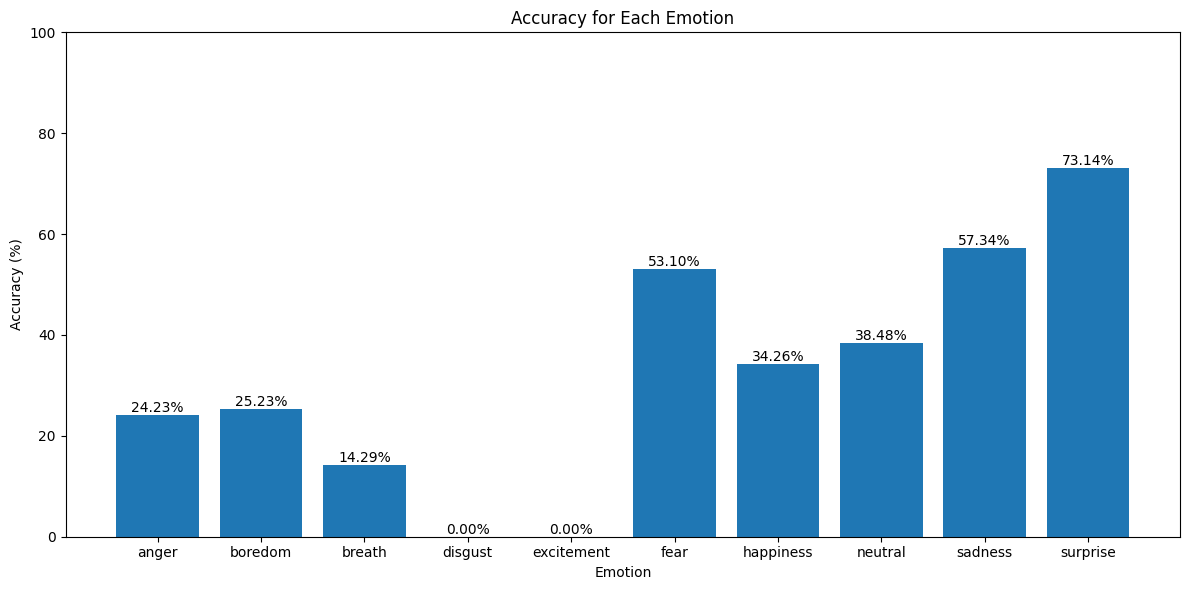

In [20]:
# Calculate accuracy for each emotion SVM
accuracies = []

# Define emotion labels
emotion_labels_svm = ['anger', 'boredom', 'breath', 'disgust', 'excitement', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

for i in range(len(emotion_labels_svm)):
    correct_predictions = confusion_svm[i, i]
    total_predictions = sum(confusion_svm[i, :])  # Sum of the row for class i
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracies.append(accuracy)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(emotion_labels_svm, [accuracy * 100 for accuracy in accuracies])  # Convert accuracies to percentages
plt.xlabel('Emotion')
plt.ylabel('Accuracy (%)')  # Change the ylabel to 'Accuracy (%)'
plt.title('Accuracy for Each Emotion')
plt.ylim(0, 100)  # Set the y-axis limit to the range [0, 100]

# Display the accuracy values on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy * 100, f'{accuracy * 100:.2f}%', ha='center', va='bottom')  # Convert accuracy to percentage

# Show the plot
plt.tight_layout()
plt.show()

Convolutional Neural Networks (CNNs)

In [28]:
# Load and preprocess the dataset
X_mfcc_features, y_labels = load_and_preprocess_data()

# Encode emotion labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

# Pad MFCC sequences to have the same length (use the maximum sequence length)
max_length = max([len(mfcc) for mfcc in X_mfcc_features])
X_mfcc_features_padded = pad_sequences(X_mfcc_features, maxlen=max_length, padding='post', dtype='float32')

# Convert X_mfcc_features_padded to a NumPy array
X_mfcc_features_padded = np.array(X_mfcc_features_padded)

# Define the number of classes (emotions)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mfcc_features_padded, y_encoded, test_size=0.2, random_state=42)

In [22]:
# Define the CNN model
model_cnn = Sequential([
    Input(shape=X_mfcc_features_padded.shape[1:]),  # Input shape based on your MFCC feature dimension
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer with classes based on your emotion categories
])

# Compile the model
model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy for integer-encoded labels
              metrics=['accuracy'])

# Train the model
model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
print(f'Test Accuracy for CNNs :', round(test_acc,3) * 100 ,'%')

# Make predictions
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Decode encoded labels back to original emotions
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Generate a classification report and confusion matrix
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    report_cnn = classification_report(y_test_original, y_pred_original)
print('Classification Report:\n', report_cnn)

confusion_cnn = confusion_matrix(y_test_original, y_pred_original)
print('Confusion Matrix:\n', confusion_cnn)

Epoch 1/10
242/242 [==============================] - 6s 24ms/step - loss: 2.8118 - accuracy: 0.2249 - val_loss: 1.9216 - val_accuracy: 0.3171
Epoch 2/10
242/242 [==============================] - 6s 23ms/step - loss: 1.8919 - accuracy: 0.3271 - val_loss: 1.8609 - val_accuracy: 0.3575
Epoch 3/10
242/242 [==============================] - 5s 22ms/step - loss: 1.7552 - accuracy: 0.3852 - val_loss: 1.7479 - val_accuracy: 0.3864
Epoch 4/10
242/242 [==============================] - 6s 23ms/step - loss: 1.6431 - accuracy: 0.4250 - val_loss: 1.7231 - val_accuracy: 0.4165
Epoch 5/10
242/242 [==============================] - 6s 23ms/step - loss: 1.5414 - accuracy: 0.4663 - val_loss: 1.6983 - val_accuracy: 0.4190
Epoch 6/10
242/242 [==============================] - 5s 23ms/step - loss: 1.4386 - accuracy: 0.5016 - val_loss: 1.7294 - val_accuracy: 0.4371
Epoch 7/10
242/242 [==============================] - 6s 23ms/step - loss: 1.3210 - accuracy: 0.5395 - val_loss: 1.6759 - val_accuracy: 0.4454

In [36]:
# Define a confidence threshold (e.g., 0.7)
confidence_threshold = 0.7
max_probabilities = np.max(y_pred, axis=1)
low_confidence_indices = np.where(max_probabilities < confidence_threshold)[0]
print(low_confidence_indices)

[   0    1    2 ... 2414 2415 2416]


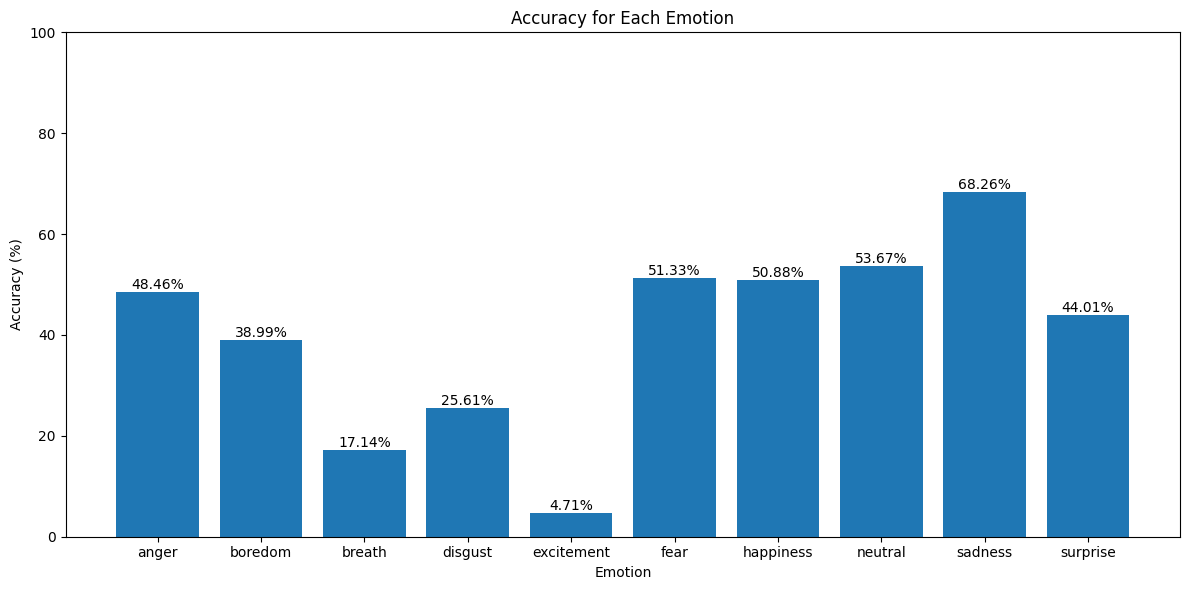

In [23]:
# Calculate accuracy for each emotion
accuracies = []
for i in range(num_classes):
    correct_predictions = confusion_cnn[i, i]
    total_predictions = sum(confusion_cnn[i, :])  # Sum of the row for class i
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracies.append(accuracy)

# Define emotion labels (from label_encoder.classes_)
emotion_labels = label_encoder.classes_

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(emotion_labels, [accuracy * 100 for accuracy in accuracies])  # Convert accuracies to percentages
plt.xlabel('Emotion')
plt.ylabel('Accuracy (%)')  # Change the ylabel to 'Accuracy (%)'
plt.title('Accuracy for Each Emotion')
plt.ylim(0, 100)  # Set the y-axis limit to the range [0, 100]

# Display the accuracy values on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy * 100, f'{accuracy * 100:.2f}%', ha='center', va='bottom')  # Convert accuracy to percentage

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Save your trained model
# model_cnn.save('cnns_model')
# model_cnn.save_weights('cnns_model/model_weights.h5')

INFO:tensorflow:Assets written to: cnns_model/assets


INFO:tensorflow:Assets written to: cnns_model/assets


Recurrent Neural Networks (RNNs)

In [26]:
# Define the RNN model
# model_rnn = Sequential([
#     SimpleRNN(128, return_sequences=True, input_shape=(max_length, X_mfcc_features_padded.shape[2])),
#     SimpleRNN(64),
#     Dense(num_classes, activation='softmax')  # Output layer with classes based on your emotion categories
# ])

# # Compile the model
# model_rnn.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy for integer-encoded labels
#               metrics=['accuracy'])

# # Train the model
# model_rnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model
# test_loss, test_acc = model_rnn.evaluate(X_test, y_test)
# print(f'Test Accuracy for RNNs :', round(test_acc,3) * 100 ,'%')

# # Make predictions
# y_pred = model_rnn.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Decode encoded labels back to original emotions
# y_test_original = label_encoder.inverse_transform(y_test)
# y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# # Generate a classification report and confusion matrix
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=UserWarning)

#     report_rnn = classification_report(y_test_original, y_pred_original)
# print('Classification Report:\n', report_rnn)

# confusion_rnn = confusion_matrix(y_test_original, y_pred_original)
# print('Confusion Matrix:\n', confusion_rnn)

Epoch 1/10
242/242 [==============================] - 66s 269ms/step - loss: 2.2358 - accuracy: 0.1433 - val_loss: 2.2272 - val_accuracy: 0.1350
Epoch 2/10
242/242 [==============================] - 67s 278ms/step - loss: 2.2168 - accuracy: 0.1381 - val_loss: 2.2293 - val_accuracy: 0.1309
Epoch 3/10
242/242 [==============================] - 65s 268ms/step - loss: 2.2183 - accuracy: 0.1361 - val_loss: 2.2287 - val_accuracy: 0.1505
Epoch 4/10
242/242 [==============================] - 64s 266ms/step - loss: 2.2158 - accuracy: 0.1438 - val_loss: 2.2313 - val_accuracy: 0.1361
Epoch 5/10
242/242 [==============================] - 66s 273ms/step - loss: 2.2191 - accuracy: 0.1454 - val_loss: 2.2246 - val_accuracy: 0.1485
Epoch 6/10
242/242 [==============================] - 65s 268ms/step - loss: 2.2121 - accuracy: 0.1454 - val_loss: 2.2209 - val_accuracy: 0.1438
Epoch 7/10
242/242 [==============================] - 64s 263ms/step - loss: 2.2092 - accuracy: 0.1442 - val_loss: 2.2215 - val_ac

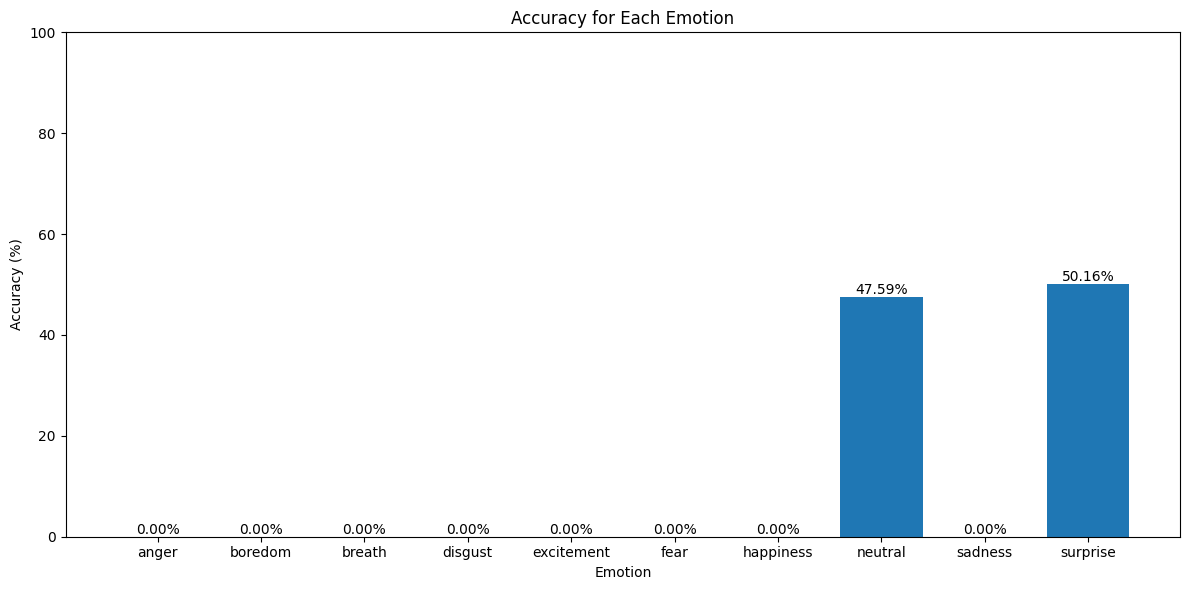

In [27]:
# Calculate accuracy for each emotion
# accuracies = []
# for i in range(num_classes):
#     correct_predictions = confusion_rnn[i, i]
#     total_predictions = sum(confusion_rnn[i, :])  # Sum of the row for class i
#     accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
#     accuracies.append(accuracy)

# # Define emotion labels (from label_encoder.classes_)
# emotion_labels = label_encoder.classes_

# # Plot the bar chart
# plt.figure(figsize=(12, 6))
# plt.bar(emotion_labels, [accuracy * 100 for accuracy in accuracies])  # Convert accuracies to percentages
# plt.xlabel('Emotion')
# plt.ylabel('Accuracy (%)')  # Change the ylabel to 'Accuracy (%)'
# plt.title('Accuracy for Each Emotion')
# plt.ylim(0, 100)  # Set the y-axis limit to the range [0, 100]

# # Display the accuracy values on top of the bars
# for i, accuracy in enumerate(accuracies):
#     plt.text(i, accuracy * 100, f'{accuracy * 100:.2f}%', ha='center', va='bottom')  # Convert accuracy to percentage

# # Show the plot
# plt.tight_layout()
# plt.show()

CNN-RNN Hybrid model

In [ ]:
# Reshape MFCC features for CNN input
# X_train_cnn = X_train[..., np.newaxis]  # Add a channe0l dimension
# X_test_cnn = X_test[..., np.newaxis]

# # Define the CNN-RNN Hybrid model
# model = Sequential([
#     Conv2D(64, (3, 3), activation='relu', input_shape=X_train_cnn[0].shape),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     TimeDistributed(Flatten()),  # Apply Flatten to each time step
#     SimpleRNN(64, return_sequences=True),  # RNN layer after CNN
#     SimpleRNN(64),
#     Dense(64, activation='relu'),
#     Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with classes based on your emotion categories
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy for integer-encoded labels
#               metrics=['accuracy'])

# # Train the model
# model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model
# test_loss, test_acc = model.evaluate(X_test_cnn, y_test)
# print(f'Test Accuracy for Hybrid :', round(test_acc,3) * 100 ,'%')

# # Make predictions
# y_pred = model.predict(X_test_cnn)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Decode encoded labels back to original emotions
# y_test_original = label_encoder.inverse_transform(y_test)
# y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# # Generate a classification report and confusion matrix
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=UserWarning)

#     report = classification_report(y_test_original, y_pred_original)
# print('Classification Report:\n', report)

# confusion = confusion_matrix(y_test_original, y_pred_original)
# print('Confusion Matrix:\n', confusion)

In [ ]:
# # Load and preprocess the dataset
# X_mfcc_features, y = load_and_preprocess_data()

# # Pad MFCC sequences to have the same length (use the maximum sequence length)
# max_length = max([len(mfcc) for mfcc in X_mfcc_features])
# X_mfcc_features_padded = pad_sequences(X_mfcc_features, maxlen=max_length, padding='post', dtype='float32')

# # Encode emotion labels (convert them to numerical values)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Convert labels to one-hot encoding
# y_onehot = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_mfcc_features_padded, y_onehot, test_size=0.2, random_state=42)

# # Define the neural network model
# model = Sequential([
#     Input(shape=(max_length, X_mfcc_features_padded.shape[2])),  # Define input shape based on your feature dimension
#     LSTM(128, activation='relu', return_sequences=True),
#     Dropout(0.5),
#     LSTM(64, activation='relu'),
#     Dropout(0.5),
#     Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with classes based on your emotion categories
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',  # Use categorical cross-entropy for one-hot encoded labels
#               metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)

# # Evaluate the model
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print(f'Test accuracy: {test_acc}')

# # Make predictions
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Decode one-hot encoded labels back to original emotions
# y_test_original = label_encoder.inverse_transform(np.argmax(y_test, axis=1))
# y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# # Generate a classification report and confusion matrix
# report = classification_report(y_test_original, y_pred_original)
# print('Classification Report:\n', report)

# confusion = confusion_matrix(y_test_original, y_pred_original)
# print('Confusion Matrix:\n', confusion)